# Data cleaning & Integration

## Libraries

In [1]:
pip install fastexcel

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 12.6 MB/s eta 0:00:00


In [2]:
pip install xlsxwriter

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.4/169.4 kB 2.8 MB/s eta 0:00:00


In [10]:
pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.8 MB/s eta 0:00:00


Side note: It will be useful to put all the required libraries in a requirements.txt file

In [18]:
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns

from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve

## Global variables

In [4]:
# Input paths
PATH_DATAFRAME = 'full_join.xlsx'

## Global functions

### 1. Read excel files with Polars

In [5]:
def polars_read_excel(file_name, sheet_name='Sheet1'):
  return pl.read_excel(source=file_name, sheet_name=sheet_name)

## Model development

### 1. File reading

In [6]:
df = polars_read_excel(PATH_DATAFRAME)

### 2. Column type

In [7]:
df = df.with_columns([
    pl.col("CostImpact (€)").cast(pl.Float64, strict=False),
])

### 3. Data selection

In [8]:
df_input = (
    df
    .filter(pl.col("PackagesHandled") > 0)
    .filter(pl.col("PackagingQuality").is_in(["Bad", "Good"]))
    .with_columns([
        pl.col("DateOfReport").dt.month().alias("Month"),
        pl.col("DateOfReport").dt.day().alias("Day"),
        pl.col("DateOfReport").dt.weekday().alias("Weekday"),
        (pl.col("TotalIncidents") / pl.col("PackagesHandled")).alias("TotalIncidents (%)"),
        (pl.col("AnomaliesDetected") / pl.col("PackagesHandled")).alias("AnomaliesDetected (%)")
    ])
    .order_by("DateOfReport")
    .select([
        "Month",
        "Day",
        "Weekday",
        "SupplierName",
        "GarmentType",
        "Material",
        "Weight",
        "ProposedUnitsPerCarton",
        "ProposedFoldingMethod",
        "ProposedLayout",
        "Size",
        "Collection",
        "TotalIncidents (%)",
        "AnomaliesDetected (%)",
        "BadPackagingRate (%)",
        "OnTimeDeliveryRate (%)",
        "AverageCostPerIncident (€)",
        "PackagingQuality"
    ])
)

### 4. Categorical boosting

#### 4.1 Training

In [21]:
# Convert Polars to Pandas
df_pd = df_input.to_pandas()

# Encode target variable
df_pd["PackagingQuality"] = df_pd["PackagingQuality"].map({"Good": 1, "Bad": 0})

# Define features and target
X = df_pd.drop(columns=["PackagingQuality"])
y = df_pd["PackagingQuality"]

# Identify categorical columns
categorical_features = X.select_dtypes(include="object").columns.tolist()

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Create CatBoost Pool
train_pool = Pool(X_train, y_train, cat_features=categorical_features)
test_pool = Pool(X_test, y_test, cat_features=categorical_features)

# Train CatBoost Classifier
model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.1,
    class_weights=[3, 1],
    depth=5,
    eval_metric='Accuracy',
    random_seed=42,
    verbose=100
)

model.fit(train_pool, eval_set=test_pool)

0:	learn: 0.6471826	test: 0.6448542	best: 0.6448542 (0)	total: 579ms	remaining: 4m 48s
100:	learn: 0.6503868	test: 0.6465014	best: 0.6466672 (66)	total: 48.5s	remaining: 3m 11s
200:	learn: 0.6523739	test: 0.6464532	best: 0.6471859 (177)	total: 1m 40s	remaining: 2m 29s
300:	learn: 0.6544757	test: 0.6466618	best: 0.6471859 (177)	total: 2m 34s	remaining: 1m 42s
400:	learn: 0.6562198	test: 0.6466190	best: 0.6471859 (177)	total: 3m 31s	remaining: 52.1s
499:	learn: 0.6574758	test: 0.6466030	best: 0.6471859 (177)	total: 4m 25s	remaining: 0us

bestTest = 0.6471859157
bestIteration = 177

Shrink model to first 178 iterations.


#### 4.2 Evaluating

In [22]:
# Summary report
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.33      0.51      0.40     26481
           1       0.86      0.75      0.80    107545

    accuracy                           0.70    134026
   macro avg       0.60      0.63      0.60    134026
weighted avg       0.76      0.70      0.72    134026



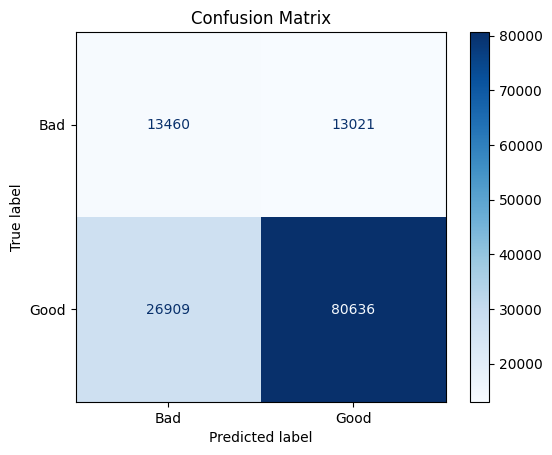

In [23]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Bad", "Good"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

AUC: 0.6978


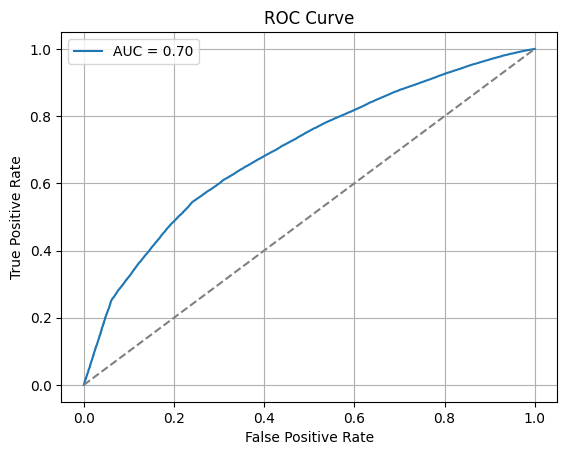

In [24]:
# Get predicted probabilities for the positive class ("Good" = 1)
y_proba = model.predict_proba(X_test)[:, 1]

# AUC score
auc_score = roc_auc_score(y_test, y_proba)
print(f"AUC: {auc_score:.4f}")

# Optional: plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

In [27]:
# Get feature names and importance values
importance_df = pd.DataFrame({
    "Feature": model.feature_names_,
    "Importance": model.get_feature_importance()
}).sort_values(by="Importance", ascending=False)

# Display top features
importance_df

,Feature,Importance
14,BadPackagingRate (%),25.364009
8,ProposedFoldingMethod,17.180522
12,TotalIncidents (%),12.466402
15,OnTimeDeliveryRate (%),11.179392
5,Material,10.004282
6,Weight,6.978328
3,SupplierName,5.622866
7,ProposedUnitsPerCarton,3.950754
13,AnomaliesDetected (%),1.598828
16,AverageCostPerIncident (€),1.082706
